<a href="https://colab.research.google.com/github/muhammadabdulbaqi/LSTM/blob/main/DSD_LSTMw_multipleinputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
file = "/content/drive/MyDrive/IBM_data.csv"

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(file)

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,199.97,202.090,199.68,201.68,2893254,IBM
1,2013-02-11,200.98,201.950,199.75,200.16,2944651,IBM
2,2013-02-12,200.01,200.735,199.02,200.04,2461779,IBM
3,2013-02-13,200.65,200.950,199.57,200.09,2169757,IBM
4,2013-02-14,199.73,200.320,199.26,199.65,3294126,IBM


In [ ]:
print(df.isnull().sum())


date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


In [ ]:
df['date'] = pd.to_datetime(df['date'])


In [ ]:
print(df['date'])

0      2013-02-08
1      2013-02-11
2      2013-02-12
3      2013-02-13
4      2013-02-14
          ...    
1254   2018-02-01
1255   2018-02-02
1256   2018-02-05
1257   2018-02-06
1258   2018-02-07
Name: date, Length: 1259, dtype: datetime64[ns]


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Attention, concatenate

In [ ]:
df = df.sort_values('date')

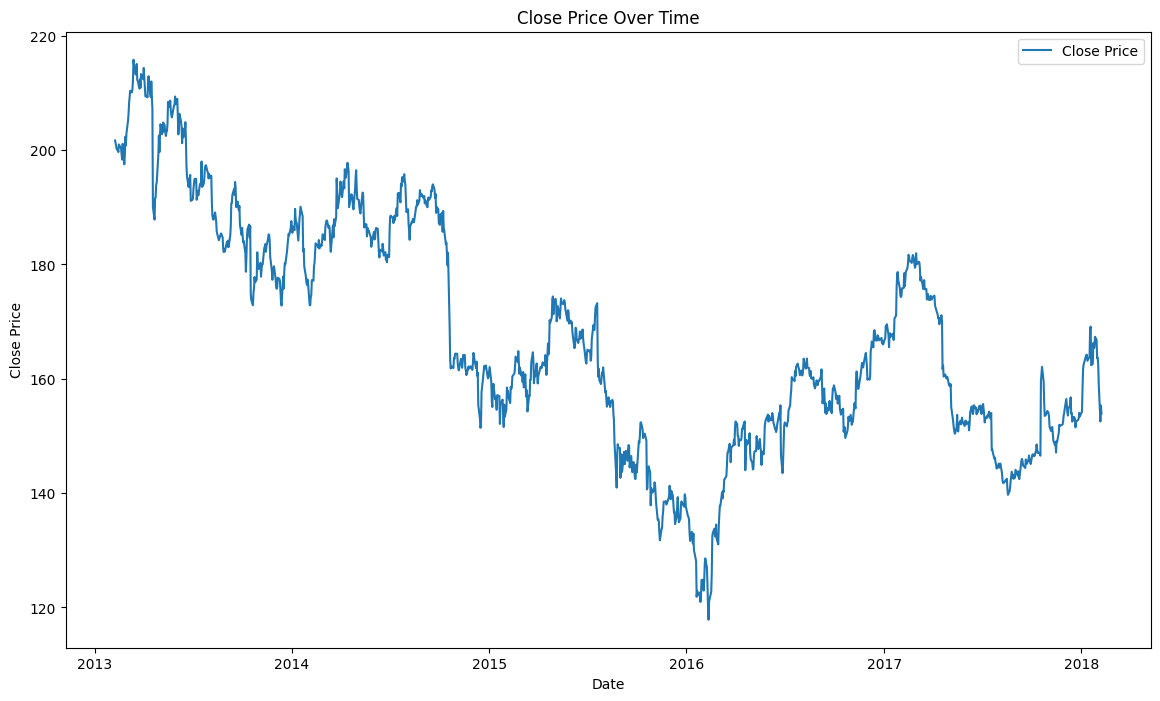

In [ ]:
# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Splitting into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['open', 'close']])  # Scale 'Open' and 'Close'
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

In [ ]:
def create_sequences(data, offset=60):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i - offset:i])  # Past `offset` days
        y.append(data[i, 1])  # Target is 'Close'
    return np.array(X), np.array(y)

# Create sequences for training and testing
offset = 60
X_train, y_train = create_sequences(train_scaled, offset)
X_test, y_test = create_sequences(test_scaled, offset)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (947, 60, 2), y_train shape: (947,)
X_test shape: (192, 60, 2), y_test shape: (192,)


In [ ]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Attention scores
        e = tf.math.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        # Apply attention to the input sequence
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])  # Output shape is (batch_size, feature_dim)





In [ ]:
def build_attention_lstm(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, return_sequences=True)(inputs)  # Keep return_sequences=True for attention
    attention = AttentionLayer()(lstm_out)
    dense = Dense(1)(attention)  # Final prediction
    model = Model(inputs, dense)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and summarize the model
model = build_attention_lstm((X_train.shape[1], X_train.shape[2]))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 64)                  │             124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,341 (67.74 KB)

 Trainable params: 17,341 (67.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0364 - val_loss: 0.0094
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071 - val_loss: 0.0081
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

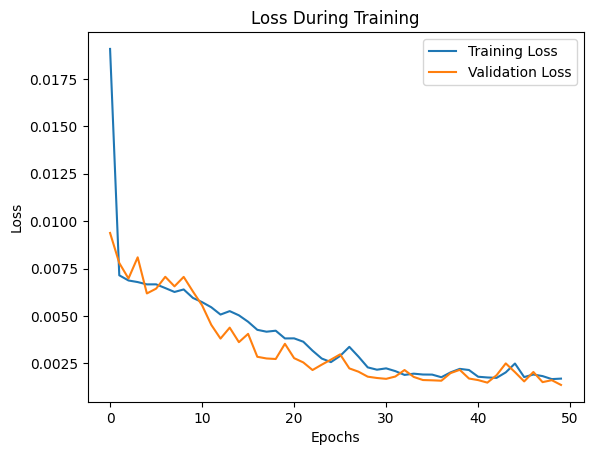

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")


Test Loss: 0.0013636955991387367


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


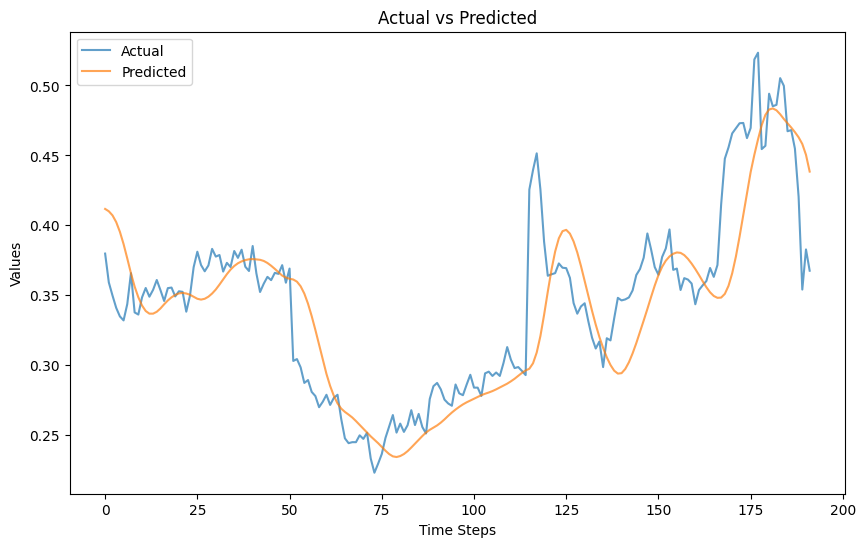

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
model.save('attention_lstm_model.h5')
